In [2]:
import pandas as pd
from Levenshtein import editops, distance
from collections import Counter

In [97]:
df = pd.read_csv('a_utf8.csv', encoding='utf-8', low_memory=False)

In [98]:
unique_errors = df[df['new_ngram'].notna()].drop_duplicates(subset='n_gram')

In [99]:
unique_all = pd.concat([df[df['new_ngram'].notna()], df[df['is_bastard']==0]], axis=0, ignore_index=True).drop_duplicates(subset='n_gram')

In [103]:
len(unique_all)

179

In [100]:
not_to_correct = unique_all[unique_all['is_bastard']==0]

In [101]:
unique_all.loc[not_to_correct.index, ['new_ngram']] = not_to_correct['n_gram']

In [104]:
corrections = unique_errors['new_ngram'].astype(str).tolist()
errors = unique_errors['n_gram'].astype(str).tolist()

In [105]:
with_all = unique_all['new_ngram'].astype(str).tolist()
with_errors = unique_all['n_gram'].astype(str).tolist()

In [110]:
dists=[]
edit_ops=[]

In [111]:
for pair in zip(corrections, errors):
    print(pair)
    print(distance(pair[0],pair[1]))
    dists.append(distance(pair[0],pair[1]))

('АКАДЕМІИ', 'АКАДЕНШ')
3
('НАРОДНОЕ', 'АРОДНОЕ')
1
('Августа', 'Авгуота')
1
('Августъ', 'Августь')
1
('Австріи', 'Австрж')
2
('Агаѳангела', 'Агаоангела')
1
('Аѳанасьевской', 'Аеанасьевской')
1
('Аѳонасій', 'Аеонасш')
3
('Аѳонѣ', 'Аеонт')
2
('Australian', 'Аиз1гаНап')
10
('Акcаковъ', 'Акеаковъ')
1
('Алекcея', 'Алекеея')
1
('Алексѣй', 'АлексЪй')
1
('Александринскаго', 'Александрннскаго')
1
('Александровича', 'Александровича2')
1
('Александровскаго', 'Александровскаю')
2
('Алексѣя', 'Алексая')
1
('Альпійскую', 'Альшйскую')
2
('Амфилохія', 'Амфилохгя')
1
('Анастасія', 'Анасташ')
3
('Анатоліе', 'Анатолге')
1
('Андреевичъ', 'Андреевпчъ')
1
('Апостолы', 'Аностолы')
1
('Арестованіе', 'Арестоваше')
2
('Арзамасскій', 'Арзамасскш')
2
('Артиллерійскаго', 'АртиллерШскаго')
2
('Архангельскій', 'Архангельскш')
2
('Архіерейскаго', 'Архгерейскаго')
1
('Архимандритовъ', 'АрхимандритовЪ')
1
('Aceraceae', 'Асегасеае')
9
('Афанасій', 'Афанасш')
2
('дѣятелей', 'Ъятелей')
2
('Lazare', 'Ьагаге')
6
('Lady', '

In [108]:
dist_counts = Counter(dists)

In [112]:
print('''
{} % of errors have edit distance 1\n
{} % of errors have edit distance 2\n
{} % of errors have edit distance 3\n
{} % of errors have edit distance more than 3 (probably it is transliteration)
'''.format(dist_counts[1]/len(dists)*100, 
           dist_counts[2]/len(dists)*100, 
           dist_counts[3]/len(dists)*100,
           (len(dists)-dist_counts[1]-dist_counts[2]-dist_counts[3])/len(dists)*100))


57.25806451612904 % of errors have edit distance 1

22.58064516129032 % of errors have edit distance 2

10.483870967741936 % of errors have edit distance 3

9.67741935483871 % of errors have edit distance more than 3 (probably it is transliteration)



In [113]:
error_df=''

In [114]:
for pair in zip(with_all, with_errors):
    if len(editops(pair[0],pair[1]))==1 or len(editops(pair[0],pair[1]))==0:
        if len(editops(pair[0],pair[1]))==1:
            editop, idxw, idxx = editops(pair[0],pair[1])[0]
            if editop == 'replace':
                correct_char=pair[0][idxw]
                error_char=pair[1][idxx]
                ew=pair[1][idxx]+'|'+pair[0][idxw]
            elif editop == 'insert':
                correct_char = '-'
                error_char = pair[1][idxx]
                ew=pair[1][idxx-1:idxx+1]+'|'+pair[0][idxw-1]
            elif editop == 'delete':
                correct_char = pair[0][idxw]
                error_char = '-'
                if idxx!=0:
                    ew=pair[1][idxx-1]+'|'+pair[0][idxw-1:idxw+1]
                else:
                    ew=pair[1][idxx]+'|'+pair[0][idxw:idxw+2]
            df_temp = pd.DataFrame([[pair[0],
                                  pair[1],
                                  editop,
                                  correct_char,
                                 idxw,
                                 error_char,
                                 idxx,
                                 ew]],columns=['correction',
                                               'error', 
                                               'editop', 
                                                             'correct_char',
                                                           'idxw',
                                                             'error_char',
                                                           'idxe',
                                                             'e|w'])

        elif len(editops(pair[0],pair[1]))==0:
            editop, idxw, idxx = ('equal', 0, 0)
            correct_char = '-'
            error_char = '-'
            ew='|'
            df_temp = pd.DataFrame([[pair[0],
                                      pair[1],
                                      editop,
                                      correct_char,
                                     idxw,
                                     error_char,
                                     idxx,
                                     ew]],columns=['correction',
                                                   'error', 
                                                   'editop', 
                                                   'correct_char',
                                                   'idxw',
                                                   'error_char',
                                                               'idxe',
                                                                 'e|w'])
        if not len(error_df):
            error_df=df_temp
        else:
            error_df=pd.concat([error_df,df_temp],axis=0,ignore_index=True)
    else:
        pass

In [131]:
error_df[:20]

,correction,error,editop,correct_char,idxw,error_char,idxe,e|w
0,НАРОДНОЕ,АРОДНОЕ,delete,Н,0,-,0,А|НА
1,Августа,Авгуота,replace,с,4,о,4,о|с
2,Августъ,Августь,replace,ъ,6,ь,6,ь|ъ
3,Агаѳангела,Агаоангела,replace,ѳ,3,о,3,о|ѳ
4,Аѳанасьевской,Аеанасьевской,replace,ѳ,1,е,1,е|ѳ
5,Акcаковъ,Акеаковъ,replace,c,2,е,2,е|c
6,Алекcея,Алекеея,replace,c,4,е,4,е|c
7,Алексѣй,АлексЪй,replace,ѣ,5,Ъ,5,Ъ|ѣ
8,Александринскаго,Александрннскаго,replace,и,9,н,9,н|и
9,Александровича,Александровича2,insert,-,14,2,14,а2|а


<img src="pics/Снимок.PNG",width=600, height=300>
see https://web.stanford.edu/~jurafsky/slp3/B.pdf

In [134]:
sub_df = pd.concat([error_df[error_df['editop']=='replace'], error_df[error_df['editop']=='equal']], axis=0, ignore_index=True)
del_df = pd.concat([error_df[error_df['editop']=='delete'], error_df[error_df['editop']=='equal']], axis=0, ignore_index=True)
ins_df = pd.concat([error_df[error_df['editop']=='insert'], error_df[error_df['editop']=='equal']], axis=0, ignore_index=True)

In [135]:
correct_tokens = [list(word[:int(error_df.idxw.iloc[[i]])])+[error_df['e|w'].iloc[[i]][i][error_df['e|w'].iloc[[i]][i].find('|')+1:]]+list(word[int(error_df.idxw.iloc[[i]])+len(error_df['e|w'].iloc[[i]][i][error_df['e|w'].iloc[[i]][i].find('|')+1:]):]) for i, word in enumerate(error_df['correction'].astype(str).tolist())]
correct_subs = [list(word[:int(sub_df.idxw.iloc[[i]])])+[sub_df['e|w'].iloc[[i]][i][sub_df['e|w'].iloc[[i]][i].find('|')+1:]]+list(word[int(sub_df.idxw.iloc[[i]])+len(sub_df['e|w'].iloc[[i]][i][sub_df['e|w'].iloc[[i]][i].find('|')+1:]):]) for i, word in enumerate(sub_df['correction'].astype(str).tolist())]
correct_dels = [list(word[:int(del_df.idxw.iloc[[i]])])+[del_df['e|w'].iloc[[i]][i][del_df['e|w'].iloc[[i]][i].find('|')+1:]]+list(word[int(del_df.idxw.iloc[[i]])+len(del_df['e|w'].iloc[[i]][i][del_df['e|w'].iloc[[i]][i].find('|')+1:]):]) for i, word in enumerate(del_df['correction'].astype(str).tolist())]
correct_ins = [list(word[:int(ins_df.idxw.iloc[[i]])])+[ins_df['e|w'].iloc[[i]][i][ins_df['e|w'].iloc[[i]][i].find('|')+1:]]+list(word[int(ins_df.idxw.iloc[[i]])+len(ins_df['e|w'].iloc[[i]][i][ins_df['e|w'].iloc[[i]][i].find('|')+1:]):]) for i, word in enumerate(ins_df['correction'].astype(str).tolist())]

In [136]:
correct_tokens = [[char for char in word if char] for word in correct_tokens]
correct_subs = [[char for char in word if char] for word in correct_subs]
correct_dels = [[char for char in word if char] for word in correct_dels]
correct_ins = [[char for char in word if char] for word in correct_ins]

In [140]:
correct_subs[:5]

[['А', 'в', 'г', 'у', 'с', 'т', 'а'],
 ['А', 'в', 'г', 'у', 'с', 'т', 'ъ'],
 ['А', 'г', 'а', 'ѳ', 'а', 'н', 'г', 'е', 'л', 'а'],
 ['А', 'ѳ', 'а', 'н', 'а', 'с', 'ь', 'е', 'в', 'с', 'к', 'о', 'й'],
 ['А', 'к', 'c', 'а', 'к', 'о', 'в', 'ъ']]

In [141]:
correct_elements = [el for token in correct_tokens for el in token]
correct_subs_elements = [el for token in correct_subs for el in token]
correct_dels_elements = [el for token in correct_dels for el in token]
correct_ins_elements  = [el for token in correct_ins for el in token]

In [142]:
error_tokens = [list(word[:int(error_df.idxe.iloc[[i]])])+[error_df['e|w'].iloc[[i]][i][:error_df['e|w'].iloc[[i]][i].find('|')]]+list(word[int(error_df.idxe.iloc[[i]])+len(error_df['e|w'].iloc[[i]][i][:error_df['e|w'].iloc[[i]][i].find('|')]):]) for i, word in enumerate(error_df['error'].astype(str).tolist())]
error_subs = [list(word[:int(sub_df.idxe.iloc[[i]])])+[sub_df['e|w'].iloc[[i]][i][:sub_df['e|w'].iloc[[i]][i].find('|')]]+list(word[int(sub_df.idxe.iloc[[i]])+len(sub_df['e|w'].iloc[[i]][i][:sub_df['e|w'].iloc[[i]][i].find('|')]):]) for i, word in enumerate(sub_df['error'].astype(str).tolist())]
error_dels = [list(word[:int(del_df.idxe.iloc[[i]])])+[del_df['e|w'].iloc[[i]][i][:del_df['e|w'].iloc[[i]][i].find('|')]]+list(word[int(del_df.idxe.iloc[[i]])+len(del_df['e|w'].iloc[[i]][i][:del_df['e|w'].iloc[[i]][i].find('|')]):]) for i, word in enumerate(del_df['error'].astype(str).tolist())]
error_ins = [list(word[:int(ins_df.idxe.iloc[[i]])])+[ins_df['e|w'].iloc[[i]][i][:ins_df['e|w'].iloc[[i]][i].find('|')]]+list(word[int(ins_df.idxe.iloc[[i]])+len(ins_df['e|w'].iloc[[i]][i][:ins_df['e|w'].iloc[[i]][i].find('|')]):]) for i, word in enumerate(ins_df['error'].astype(str).tolist())]

In [143]:
error_tokens = [[char for char in word if char] for word in error_tokens]
error_subs = [[char for char in word if char] for word in error_subs]
error_dels = [[char for char in word if char] for word in error_dels]
error_ins = [[char for char in word if char] for word in error_ins]

In [144]:
error_ins[:5]

[['А', 'л', 'е', 'к', 'с', 'а', 'н', 'д', 'р', 'о', 'в', 'и', 'ч', 'а', 'а2'],
 ['а', 'р', 'м', 'и', 'е', 'й', 'й3'],
 ['А', 'в', 'с', 'т', 'р', 'а', 'л', 'и', 'и', 'и1'],
 ['А', 'в', 'с', 'т', 'р', 'и', 'и', 'и1'],
 ['а', 'н', 'г', 'е', 'л', 'с', 'к', 'о', 'г', 'о']]

In [145]:
error_elements = [el for token in error_tokens for el in token]
error_subs_elements = [el for token in error_subs for el in token]
error_dels_elements = [el for token in error_dels for el in token]
error_ins_elements  = [el for token in error_ins for el in token]

#### Confusion matrix для замен

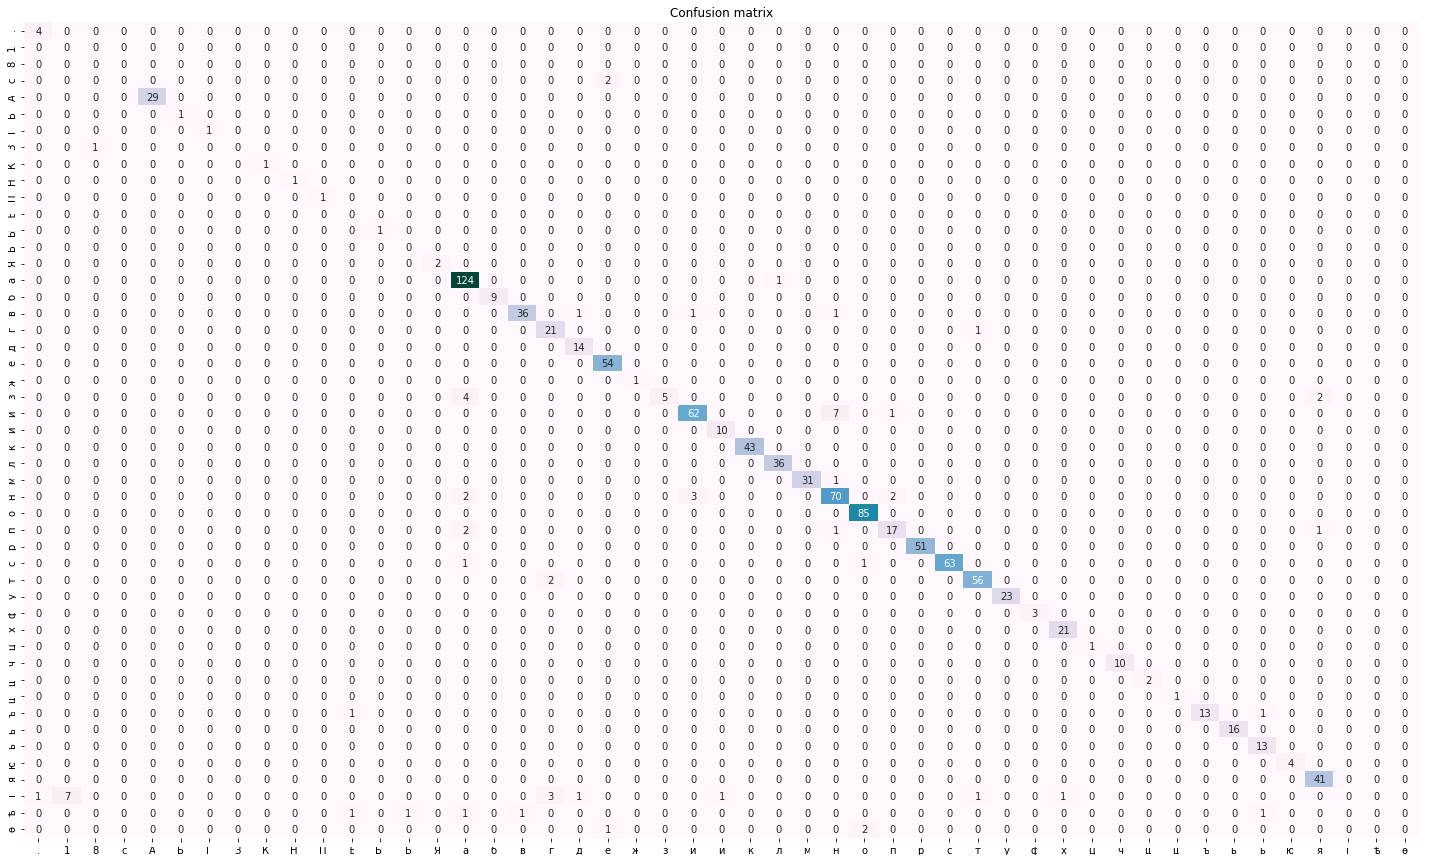

In [166]:
# alphabeth = 'í́абвгдеёжзийклмнопрстуфхцчшщъыьэюяіѣѳѵ0123456789'
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
from sklearn.feature_extraction.text import *
sub_labels = sorted(list(set(correct_subs_elements+error_subs_elements)))
plt.figure(figsize=(25,15))
sns.heatmap(data=confusion_matrix(correct_subs_elements, error_subs_elements),annot=True,fmt='d', cbar=False, xticklabels=sub_labels,yticklabels=sub_labels, cmap='PuBuGn')#,fmt='d', annot=True,)
plt.title("Confusion matrix")
plt.show()

In [165]:
confusion_matrix(correct_subs_elements, error_subs_elements)[:,15]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0, 124,   0,   0,   0,   0,   0,   0,   4,   0,   0,   0,
         0,   0,   2,   0,   2,   0,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   1,   0])

#### Для удалений

['.', 'А', 'Б', 'Г', 'Д', 'Е', 'Н', 'НА', 'О', 'П', 'Р', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'ка', 'л', 'м', 'н', 'о', 'оп', 'п', 'р', 'с', 'ст', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'ъ', 'ы', 'ь', 'ю', 'я']


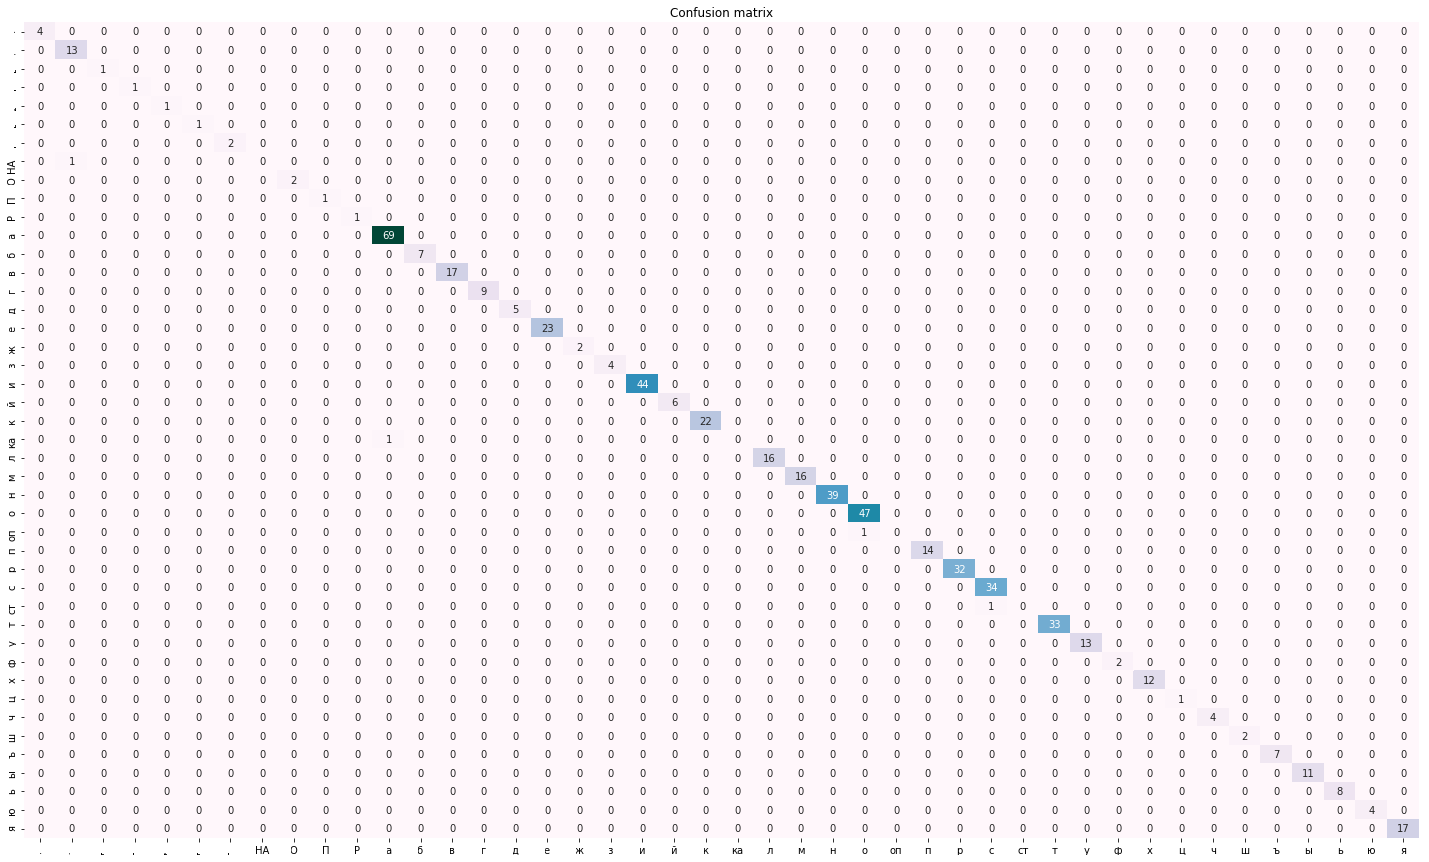

In [156]:
labels = sorted(list(set(correct_dels_elements+error_dels_elements)))
print(labels)
plt.figure(figsize=(25,15))
sns.heatmap(data=confusion_matrix(correct_dels_elements, error_dels_elements),annot=True,fmt='d', cbar=False, xticklabels=labels,yticklabels=labels, cmap='PuBuGn')#,fmt='d', annot=True,)
plt.title("Confusion matrix")
plt.show()

#### Для вставок

['.', 'А', 'Б', 'Г', 'Н', 'П', 'а', 'а2', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'и1', 'й', 'й3', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'ъ', 'ы', 'ь', 'ю', 'я']


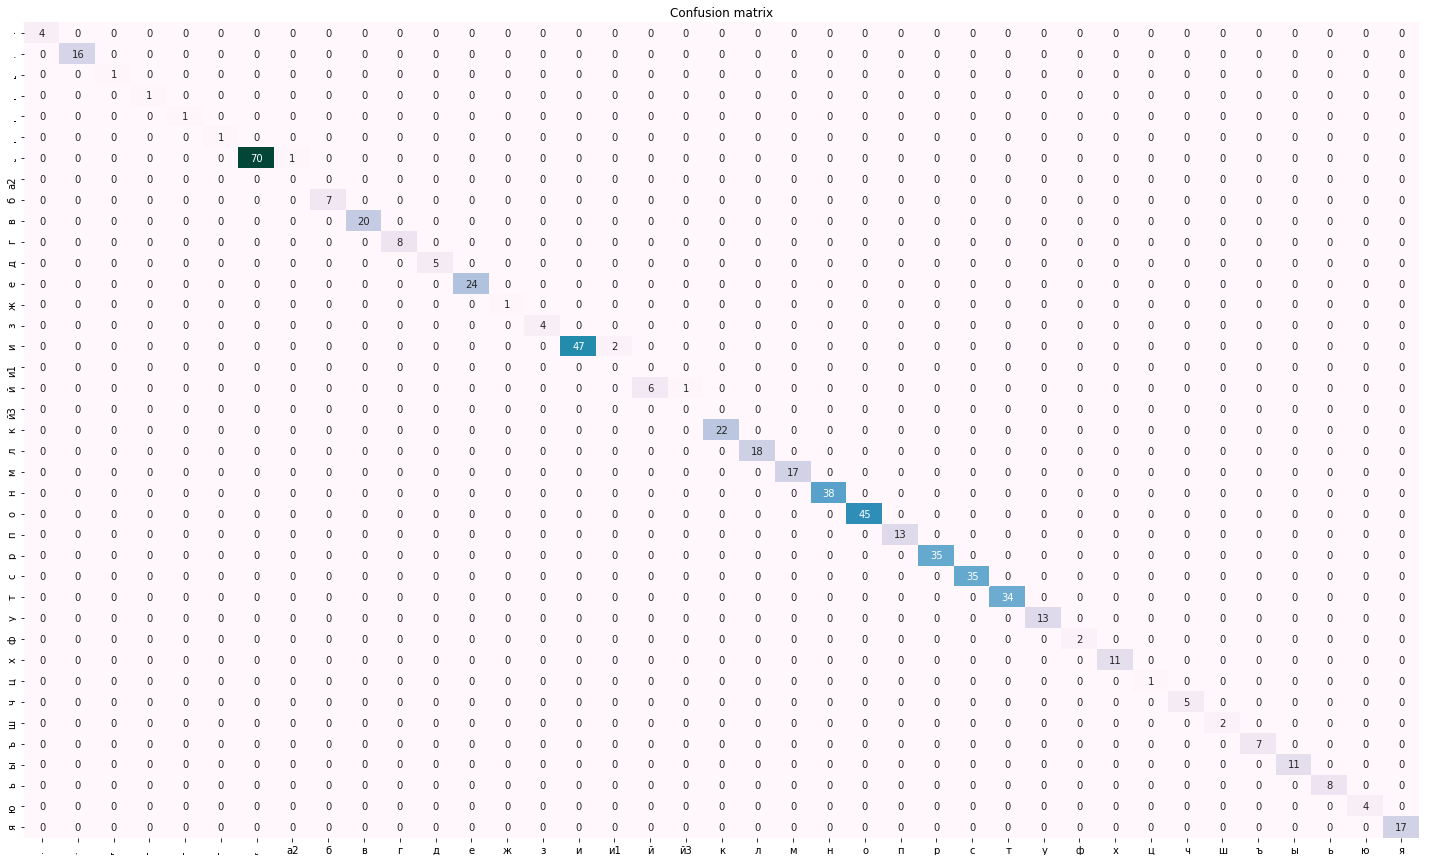

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
from sklearn.feature_extraction.text import *
labels = sorted(list(set(correct_ins_elements+error_ins_elements)))
print(labels)
plt.figure(figsize=(25,15))
sns.heatmap(data=confusion_matrix(correct_ins_elements, error_ins_elements),annot=True,fmt='d', cbar=False, xticklabels=labels,yticklabels=labels, cmap='PuBuGn')#,fmt='d', annot=True,)
plt.title("Confusion matrix")
plt.show()

In [126]:
sub_counts=Counter(error_df[error_df.editop=='replace']['e|w'].astype(str).tolist())
ins_counts=Counter(error_df[error_df.editop=='insert']['e|w'].astype(str).tolist())
del_counts=Counter(error_df[error_df.editop=='delete']['e|w'].astype(str).tolist())
char_counts=Counter([char if char!='-' else error_df['e|w'][i][-1] for i, char in enumerate(error_df.correct_char.astype(str).tolist())])

In [168]:
def P_ew(editop, ew):
    if editop=='replace':
        return check_cfsn_mtrx(sub_labels,confusion_matrix(correct_subs_elements, error_subs_elements),ew)
#     elif editop=='insert':
#         return ins_counts[ew]/char_counts[ew[-1]]
    else:
        return 0.0001 # костыль (нужно сглаживание)

In [173]:
def check_cfsn_mtrx(labels,cm,ew):
    cond_idx = ew.find('|')
    e_idx = labels.index(ew[:cond_idx])
    w_idx= labels.index(ew[cond_idx+1:])
    return(cm[w_idx, e_idx]/sum(cm[:, e_idx]))
#     confusion_matrix(correct_subs_elements, error_subs_elements)

In [174]:
P_ew('replace', 'ь|ъ')

0.06666666666666667